# Setup

In [3]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



# Perceptrons

In [4]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [5]:
y_pred

array([1])

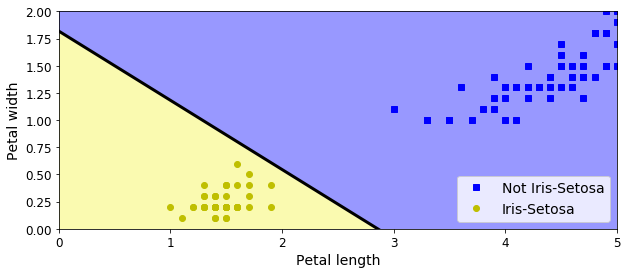

In [6]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

plt.show()

# Activation functions

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

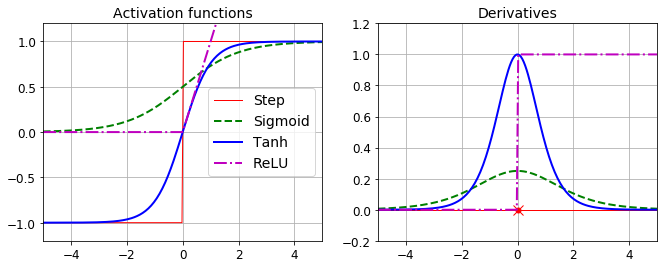

In [8]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])


plt.show()

In [9]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

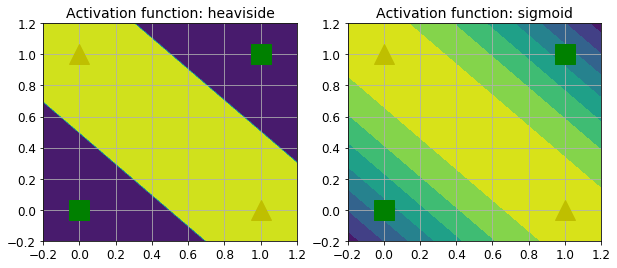

In [10]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# Building an Image Classifier

First let's import TensorFlow and Keras.

In [11]:
import tensorflow as tf
from tensorflow import keras

In [12]:
tf.__version__

'2.0.0'

In [13]:
keras.__version__

'2.2.4-tf'

- 패션 MNIST 데이터 세트를 로딩하고, 
- `keras.datasets` 함수를 이용하여 데이터를 올림. 
- 데이터는 이미 훈련과 테스트로 나누어 지고, 검증을 위해 분할도 가능

In [14]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

- 훈련 데이터는 60,000개의 회색 이미지로 크기는 28x28 픽셀이다.

In [15]:
X_train_full.shape

(60000, 28, 28)

- 각 픽셀 강도는 1바이트로 표시
- 참고로 1바이트는 8비트이고, 1비트는 0, 1이 있다
- 따라서 1byte=8bit=$2^8$으로 (0 to 255):

In [16]:
X_train_full.dtype

dtype('uint8')

- 훈련 데이터를 검증 데이터 세트로 나누고
- 각 픽셀의 강도를 0~1로 스케일 하고, 정수를 부동소수점으로 바꿔줌


In [17]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

- Matplotlib의 `imshow()`함수 및 `'binary'` 컬러 맵을 보자 

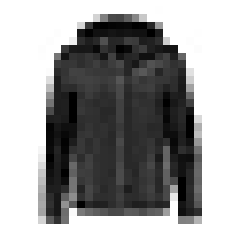

In [18]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

- 라벨은 10개 범주로 0에서 9까지 숫자로 표시 

In [19]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

- 각 법주의 이름(택)을 지어주면

In [20]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

- 훈련 데이터의 첫번째 이미지의 범주는 코트
- 1번째 이미지는 T-Shirt

In [21]:
class_names[y_train[1]]

'T-shirt/top'

- 검증 데이터 크기

In [22]:
X_train.shape

(55000, 28, 28)

In [23]:
X_valid.shape

(5000, 28, 28)

In [24]:
X_test.shape

(10000, 28, 28)

- 데이터에 있는 샘플 이미지들 살펴보자 

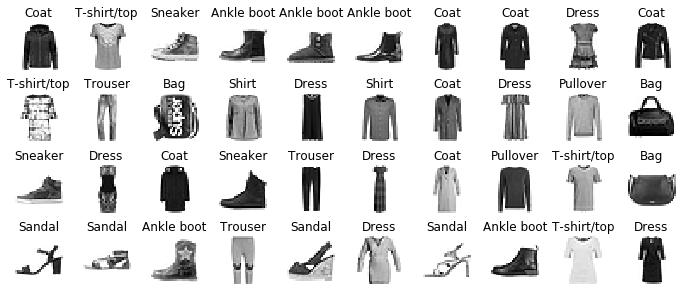

In [25]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

In [26]:
model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28, 28]))

model.add(keras.layers.Dense(300, activation="relu"))

model.add(keras.layers.Dense(100, activation="relu"))

model.add(keras.layers.Dense(10, activation="softmax"))

In [27]:
keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

In [28]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [29]:
model.layers

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


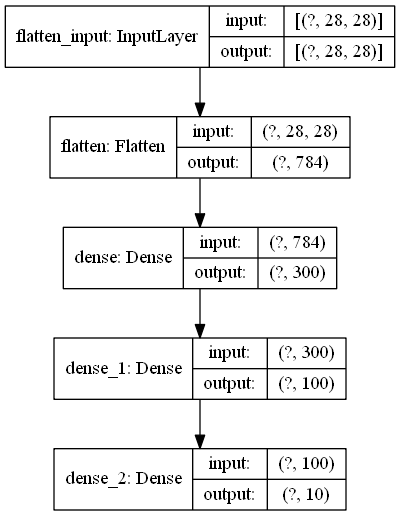

In [31]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [32]:
#!conda list


In [33]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [34]:
model.get_layer(hidden1.name) is hidden1

True

In [35]:
weights, biases = hidden1.get_weights()

In [36]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [37]:
weights.shape

(784, 300)

In [38]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [39]:
biases.shape

(300,)

In [40]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [41]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 6s 104us/sample - loss: 0.7228 - accuracy: 0.7622 - val_loss: 0.5313 - val_accuracy: 0.8140
Epoch 2/30
55000/55000 [==============================] - 6s 118us/sample - loss: 0.4838 - accuracy: 0.8323 - val_loss: 0.4492 - val_accuracy: 0.8452
Epoch 3/30
55000/55000 [==============================] - 6s 114us/sample - loss: 0.4381 - accuracy: 0.8473 - val_loss: 0.4175 - val_accuracy: 0.8558
Epoch 4/30
55000/55000 [==============================] - 7s 124us/sample - loss: 0.4128 - accuracy: 0.8557 - val_loss: 0.3898 - val_accuracy: 0.8658
Epoch 5/30
55000/55000 [==============================] - 7s 124us/sample - loss: 0.3929 - accuracy: 0.8624 - val_loss: 0.3971 - val_accuracy: 0.8624
Epoch 6/30
55000/55000 [==============================] - 8s 138us/sample - loss: 0.3775 - accuracy: 0.8671 - val_loss: 0.3737 - val_accuracy: 0.8730
Epoch 7/30
55000/55000 [===========================

In [42]:
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': 1719,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [43]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [44]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

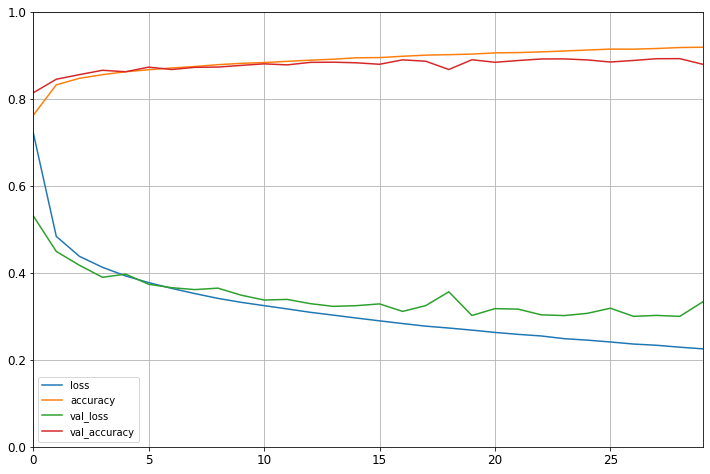

In [47]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0, 1)

plt.show()

In [48]:
model.evaluate(X_test, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.36747865749597547, 0.8663]

In [49]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.98],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [50]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1], dtype=int64)

In [51]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [52]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

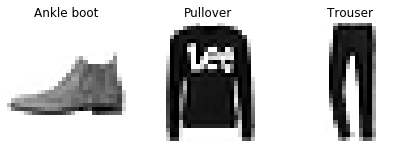

In [54]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

# Regression MLP

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [55]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [56]:
np.random.seed(42)
tf.random.set_seed(42)

In [57]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 118us/sample - loss: 1.6321 - val_loss: 1.5903
Epoch 2/20
11610/11610 [==============================] - 1s 75us/sample - loss: 0.7124 - val_loss: 0.6539
Epoch 3/20
11610/11610 [==============================] - 1s 75us/sample - loss: 0.6348 - val_loss: 0.6039
Epoch 4/20
11610/11610 [==============================] - 1s 74us/sample - loss: 0.5983 - val_loss: 0.5738
Epoch 5/20
11610/11610 [==============================] - 1s 74us/sample - loss: 0.5713 - val_loss: 0.5406
Epoch 6/20
11610/11610 [==============================] - 1s 73us/sample - loss: 0.5482 - val_loss: 0.5221
Epoch 7/20
11610/11610 [==============================] - 1s 71us/sample - loss: 0.5298 - val_loss: 0.4965
Epoch 8/20
11610/11610 [==============================] - 1s 80us/sample - loss: 0.5138 - val_loss: 0.4843
Epoch 9/20
11610/11610 [==============================] - 1s 74us/sample - loss: 0.5005 - val_

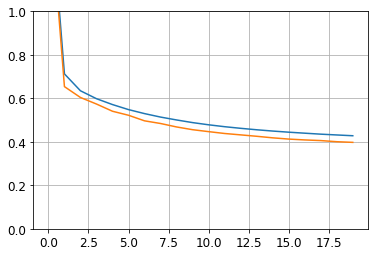

In [58]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [59]:
y_pred

array([[0.36892924],
       [1.6819052 ],
       [3.0886497 ]], dtype=float32)

# Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [60]:
np.random.seed(42)
tf.random.set_seed(42)

In [61]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [62]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]                

In [63]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 153us/sample - loss: 1.2474 - val_loss: 0.8727
Epoch 2/20
11610/11610 [==============================] - 1s 90us/sample - loss: 0.6341 - val_loss: 0.8881
Epoch 3/20
11610/11610 [==============================] - 1s 102us/sample - loss: 0.5885 - val_loss: 0.5573
Epoch 4/20
11610/11610 [==============================] - 1s 110us/sample - loss: 0.5599 - val_loss: 0.5238
Epoch 5/20
11610/11610 [==============================] - 1s 92us/sample - loss: 0.5367 - val_loss: 0.6201
Epoch 6/20
11610/11610 [==============================] - 1s 90us/sample - loss: 0.5170 - val_loss: 0.4979
Epoch 7/20
11610/11610 [==============================] - 1s 85us/sample - loss: 0.5022 - val_loss: 0.5240
Epoch 8/20
11610/11610 [==============================] - 1s 84us/sample - loss: 0.4885 - val_loss: 0.4538
Epoch 9/20
11610/11610 [==============================] - 1s 81us/sample - loss: 0.4778 - va

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [64]:
np.random.seed(42)
tf.random.set_seed(42)

In [65]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [66]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 174us/sample - loss: 1.8095 - val_loss: 1.4409
Epoch 2/20
11610/11610 [==============================] - 1s 96us/sample - loss: 0.6798 - val_loss: 0.6123
Epoch 3/20
11610/11610 [==============================] - 1s 99us/sample - loss: 0.5957 - val_loss: 0.5618
Epoch 4/20
11610/11610 [==============================] - 1s 91us/sample - loss: 0.5580 - val_loss: 0.5514
Epoch 5/20
11610/11610 [==============================] - 1s 98us/sample - loss: 0.5331 - val_loss: 0.5073
Epoch 6/20
11610/11610 [==============================] - 1s 98us/sample - loss: 0.5124 - val_loss: 0.4860
Epoch 7/20
11610/11610 [==============================] - 1s 91us/sample - loss: 0.4972 - val_loss: 0.4631
Epoch 8/20
11610/11610 [==============================] - 1s 88us/sample - loss: 0.4834 - val_loss: 0.4514
Epoch 9/20
11610/11610 [==============================] - 1s 88us/sample - loss: 0.4746 - val_

Adding an auxiliary output for regularization:

In [67]:
np.random.seed(42)
tf.random.set_seed(42)

In [68]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [69]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [70]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 212us/sample - loss: 2.1329 - main_output_loss: 1.9166 - aux_output_loss: 4.0719 - val_loss: 2.2885 - val_main_output_loss: 1.5657 - val_aux_output_loss: 8.7861
Epoch 2/20
11610/11610 [==============================] - 1s 99us/sample - loss: 0.8910 - main_output_loss: 0.6989 - aux_output_loss: 2.6202 - val_loss: 1.4258 - val_main_output_loss: 0.6285 - val_aux_output_loss: 8.5972
Epoch 3/20
11610/11610 [==============================] - 1s 106us/sample - loss: 0.7397 - main_output_loss: 0.6064 - aux_output_loss: 1.9374 - val_loss: 1.3894 - val_main_output_loss: 0.5941 - val_aux_output_loss: 8.5417
Epoch 4/20
11610/11610 [==============================] - 1s 120us/sample - loss: 0.6746 - main_output_loss: 0.5684 - aux_output_loss: 1.6301 - val_loss: 1.3275 - val_main_output_loss: 0.6028 - val_aux_output_loss: 7.8451
Epoch 5/20
11610/11610 [==============================] - 1s 110

In [71]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

# The subclassing API

In [72]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [73]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 3s 261us/sample - loss: 2.2968 - output_1_loss: 2.1826 - output_2_loss: 3.3166 - val_loss: 3.0093 - val_output_1_loss: 1.5519 - val_output_2_loss: 16.1139
Epoch 2/10
11610/11610 [==============================] - 1s 112us/sample - loss: 0.9760 - output_1_loss: 0.8529 - output_2_loss: 2.0834 - val_loss: 1.9291 - val_output_1_loss: 0.7524 - val_output_2_loss: 12.5119
Epoch 3/10
11610/11610 [==============================] - 1s 110us/sample - loss: 0.8288 - output_1_loss: 0.7270 - output_2_loss: 1.7431 - val_loss: 1.6768 - val_output_1_loss: 0.7256 - val_output_2_loss: 10.2305
Epoch 4/10
11610/11610 [==============================] - 1s 109us/sample - loss: 0.7637 - output_1_loss: 0.6744 - output_2_loss: 1.5665 - val_loss: 1.4544 - val_output_1_loss: 0.6860 - val_output_2_loss: 8.3638
Epoch 5/10
11610/11610 [==============================] - 1s 100us/sample - loss: 0.7227 - output_1_

In [74]:
model = WideAndDeepModel(30, activation="relu")

# Saving and Restoring

In [75]:
np.random.seed(42)
tf.random.set_seed(42)

In [76]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [77]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 2s 149us/sample - loss: 1.8631 - val_loss: 3.2403
Epoch 2/10
11610/11610 [==============================] - 1s 77us/sample - loss: 0.6723 - val_loss: 0.6939
Epoch 3/10
11610/11610 [==============================] - 1s 74us/sample - loss: 0.5927 - val_loss: 0.5531
Epoch 4/10
11610/11610 [==============================] - 1s 74us/sample - loss: 0.5550 - val_loss: 0.5519
Epoch 5/10
11610/11610 [==============================] - 1s 75us/sample - loss: 0.5278 - val_loss: 0.5715
Epoch 6/10
11610/11610 [==============================] - 1s 73us/sample - loss: 0.5032 - val_loss: 0.5591
Epoch 7/10
11610/11610 [==============================] - 1s 75us/sample - loss: 0.4863 - val_loss: 0.4593
Epoch 8/10
11610/11610 [==============================] - 1s 77us/sample - loss: 0.4701 - val_loss: 0.4651
Epoch 9/10
11610/11610 [==============================] - 1s 78us/sample - loss: 0.4586 - val_

In [78]:
model.save("my_keras_model.h5")

In [79]:
model = keras.models.load_model("my_keras_model.h5")

In [80]:
model.predict(X_new)

array([[0.54909724],
       [1.6584849 ],
       [3.0271606 ]], dtype=float32)

In [81]:
model.save_weights("my_keras_weights.ckpt")

In [82]:
model.load_weights("my_keras_weights.ckpt")

# Using Callbacks during Training

In [83]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [84]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [85]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 2s 175us/sample - loss: 1.8631 - val_loss: 3.2403
Epoch 2/10
11610/11610 [==============================] - 1s 76us/sample - loss: 0.6723 - val_loss: 0.6939
Epoch 3/10
11610/11610 [==============================] - 1s 79us/sample - loss: 0.5927 - val_loss: 0.5531
Epoch 4/10
11610/11610 [==============================] - 1s 77us/sample - loss: 0.5550 - val_loss: 0.5519
Epoch 5/10
11610/11610 [==============================] - 1s 75us/sample - loss: 0.5278 - val_loss: 0.5715
Epoch 6/10
11610/11610 [==============================] - 1s 78us/sample - loss: 0.5032 - val_loss: 0.5591
Epoch 7/10
11610/11610 [==============================] - 1s 81us/sample - loss: 0.4863 - val_loss: 0.4593
Epoch 8/10
11610/11610 [==============================] - 1s 76us/sample - loss: 0.4701 - val_loss: 0.4651
Epoch 9/10
11610/11610 [==============================] - 1s 98us/sample - loss: 0.4586 - val_

In [86]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 2s 145us/sample - loss: 0.4388 - val_loss: 0.4122
Epoch 2/100
11610/11610 [==============================] - 1s 83us/sample - loss: 0.4319 - val_loss: 0.4046
Epoch 3/100
11610/11610 [==============================] - 1s 75us/sample - loss: 0.4256 - val_loss: 0.4065
Epoch 4/100
11610/11610 [==============================] - 1s 92us/sample - loss: 0.4202 - val_loss: 0.3998
Epoch 5/100
11610/11610 [==============================] - 1s 96us/sample - loss: 0.4157 - val_loss: 0.3970
Epoch 6/100
11610/11610 [==============================] - 1s 78us/sample - loss: 0.4112 - val_loss: 0.3964
Epoch 7/100
11610/11610 [==============================] - 1s 80us/sample - loss: 0.4072 - val_loss: 0.3807
Epoch 8/100
11610/11610 [==============================] - 1s 76us/sample - loss: 0.4040 - val_loss: 0.3778
Epoch 9/100
11610/11610 [==============================] - 1s 71us/sample - loss: 0.40

In [87]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [88]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

Train on 11610 samples, validate on 3870 samples
11072/11610 [===========================>..] - ETA: 0s - loss: 0.3451
val/train: 1.10
11610/11610 [==============================] - 1s 92us/sample - loss: 0.3465 - val_loss: 0.3825


# TensorBoard

In [89]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [90]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2020_01_28-20_41_42'

In [91]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [92]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [93]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 92us/sample - loss: 1.8631 - val_loss: 3.2403
Epoch 2/30
11610/11610 [==============================] - 1s 47us/sample - loss: 0.6723 - val_loss: 0.6939
Epoch 3/30
11610/11610 [==============================] - 1s 51us/sample - loss: 0.5927 - val_loss: 0.5531
Epoch 4/30
11610/11610 [==============================] - 1s 51us/sample - loss: 0.5550 - val_loss: 0.5519
Epoch 5/30
11610/11610 [==============================] - 1s 50us/sample - loss: 0.5278 - val_loss: 0.5715
Epoch 6/30
11610/11610 [==============================] - 1s 55us/sample - loss: 0.5032 - val_loss: 0.5591
Epoch 7/30
11610/11610 [==============================] - 1s 52us/sample - loss: 0.4863 - val_loss: 0.4593
Epoch 8/30
11610/11610 [==============================] - 1s 54us/sample - loss: 0.4701 - val_loss: 0.4651
Epoch 9/30
11610/11610 [==============================] - 1s 51us/sample - loss: 0.4586 - val_l

To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

You can then open your web browser to [localhost:6006](http://localhost:6006) and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

Alternatively, you can load TensorBoard's Jupyter extension and run it like this:

In [94]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 19488.

In [95]:
run_logdir2 = get_run_logdir()
run_logdir2

'.\\my_logs\\run_2020_01_28-20_44_44'

In [96]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [97]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))

In [98]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 2s 145us/sample - loss: 0.7860 - val_loss: 3.9608
Epoch 2/30
11610/11610 [==============================] - 1s 84us/sample - loss: 0.4406 - val_loss: 19.3300
Epoch 3/30
11610/11610 [==============================] - 1s 115us/sample - loss: 0.3807 - val_loss: 1.9256
Epoch 4/30
11610/11610 [==============================] - 1s 105us/sample - loss: 0.4055 - val_loss: 0.3552
Epoch 5/30
11610/11610 [==============================] - 1s 92us/sample - loss: 0.3706 - val_loss: 0.3235
Epoch 6/30
11610/11610 [==============================] - 1s 85us/sample - loss: 0.3641 - val_loss: 0.3160
Epoch 7/30
11610/11610 [==============================] - 1s 88us/sample - loss: 0.3504 - val_loss: 0.3156
Epoch 8/30
11610/11610 [==============================] - 1s 82us/sample - loss: 0.3393 - val_loss: 13.7286
Epoch 9/30
11610/11610 [==============================] - 1s 83us/sample - loss: 0.3783 - 

Notice how TensorBoard now sees two runs, and you can compare the learning curves.

Check out the other available logging options:

In [99]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



# Hyperparameter Tuning

In [100]:
keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

In [101]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    
    model = keras.models.Sequential()
    
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
        
    model.add(keras.layers.Dense(1))
    
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    
    model.compile(loss="mse", optimizer=optimizer)
    
    return model

In [102]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [109]:
keras_reg.fit(X_train, y_train, epochs=20,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 157us/sample - loss: 1.4465 - val_loss: 18.8659
Epoch 2/20
11610/11610 [==============================] - 1s 84us/sample - loss: 0.7695 - val_loss: 2.4066
Epoch 3/20
11610/11610 [==============================] - 1s 87us/sample - loss: 0.5841 - val_loss: 0.5219
Epoch 4/20
11610/11610 [==============================] - 1s 91us/sample - loss: 0.5262 - val_loss: 0.4870
Epoch 5/20
11610/11610 [==============================] - 1s 89us/sample - loss: 0.4954 - val_loss: 0.4505
Epoch 6/20
11610/11610 [==============================] - 1s 104us/sample - loss: 0.4716 - val_loss: 0.4350
Epoch 7/20
11610/11610 [==============================] - 1s 103us/sample - loss: 0.4547 - val_loss: 0.4189
Epoch 8/20
11610/11610 [==============================] - 1s 93us/sample - loss: 0.4426 - val_loss: 0.4131
Epoch 9/20
11610/11610 [==============================] - 1s 97us/sample - loss: 0.4323 - v

In [110]:
mse_test = keras_reg.score(X_test, y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [111]:
y_pred = keras_reg.predict(X_new)

In [112]:
np.random.seed(42)
tf.random.set_seed(42)

In [113]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 40),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)

rnd_search_cv.fit(X_train, y_train, epochs=20,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15 ....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 212us/sample - loss: 3.5564 - val_loss: 1.8584
Epoch 2/20
7740/7740 [==============================] - 1s 96us/sample - loss: 1.3350 - val_loss: 0.9421
Epoch 3/20
7740/7740 [==============================] - 1s 89us/sample - loss: 0.8579 - val_loss: 0.7273
Epoch 4/20
7740/7740 [==============================] - 1s 105us/sample - loss: 0.7340 - val_loss: 0.9321
Epoch 5/20
7740/7740 [==============================] - 1s 94us/sample - loss: 0.6951 - val_loss: 0.6364
Epoch 6/20
7740/7740 [==============================] - 1s 88us/sample - loss: 0.6682 - val_loss: 0.8188
Epoch 7/20
7740/7740 [==============================] - 1s 99us/sample - loss: 0.6526 - val_loss: 0.7451
Epoch 8/20
7740/7740 [==============================] - 1s 91us/sample - loss: 0.6386 - val_loss: 0.6280
Epoch 9/20
7740/7740 [==============================] - 1s 89us/sample - loss: 0.6251 - val_loss: 0.6979
Epoch

[CV]  learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15, total=  16.6s
[CV] learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15 ....


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.5s remaining:    0.0s


Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 195us/sample - loss: 3.5557 - val_loss: 23.2477
Epoch 2/20
7740/7740 [==============================] - 1s 91us/sample - loss: 1.4772 - val_loss: 10.8630
Epoch 3/20
7740/7740 [==============================] - 1s 97us/sample - loss: 1.0155 - val_loss: 4.4730
Epoch 4/20
7740/7740 [==============================] - 1s 95us/sample - loss: 0.8734 - val_loss: 1.5265
Epoch 5/20
7740/7740 [==============================] - 1s 96us/sample - loss: 0.8032 - val_loss: 0.7206
Epoch 6/20
7740/7740 [==============================] - 1s 92us/sample - loss: 0.7550 - val_loss: 1.1635
Epoch 7/20
7740/7740 [==============================] - 1s 101us/sample - loss: 0.7167 - val_loss: 2.4032
Epoch 8/20
7740/7740 [==============================] - 1s 95us/sample - loss: 0.6855 - val_loss: 4.0540
Epoch 9/20
7740/7740 [==============================] - 1s 86us/sample - loss: 0.6591 - val_loss: 5.9448
Epo

[CV]  learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15, total=  11.9s
[CV] learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 1s 187us/sample - loss: 3.2689 - val_loss: 1.3818
Epoch 2/20
7740/7740 [==============================] - 1s 108us/sample - loss: 0.9650 - val_loss: 0.7308
Epoch 3/20
7740/7740 [==============================] - 1s 111us/sample - loss: 0.6171 - val_loss: 0.5392
Epoch 4/20
7740/7740 [==============================] - 1s 115us/sample - loss: 0.5491 - val_loss: 0.5124
Epoch 5/20
7740/7740 [==============================] - 1s 106us/sample - loss: 0.5355 - val_loss: 0.5908
Epoch 6/20
7740/7740 [==============================] - 1s 143us/sample - loss: 0.5310 - val_loss: 0.7897
Epoch 7/20
7740/7740 [==============================] - 1s 126us/sample - loss: 0.5344 - val_loss: 0.5654
Epoch 8/20
7740/7740 [==============================] - 1

[CV]  learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15, total=  12.8s
[CV] learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 209us/sample - loss: 1.4462 - val_loss: 5.1308
Epoch 2/20
7740/7740 [==============================] - 1s 92us/sample - loss: 0.6498 - val_loss: 12.7918
Epoch 3/20
7740/7740 [==============================] - 1s 89us/sample - loss: 0.6009 - val_loss: 0.5573
Epoch 4/20
7740/7740 [==============================] - 1s 98us/sample - loss: 0.5603 - val_loss: 2.6121
Epoch 5/20
7740/7740 [==============================] - 1s 104us/sample - loss: 0.6319 - val_loss: 151.6782
Epoch 6/20
7740/7740 [==============================] - 1s 112us/sample - loss: 1.7132 - val_loss: 528.7362
Epoch 7/20
7740/7740 [==============================] - 1s 123us/sample - loss: 6.1401 - val_loss: 2334.6831
Epoch 8/20
7740/7740 [==============================

[CV]  learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21, total=  11.3s
[CV] learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 1s 183us/sample - loss: 1.1692 - val_loss: 23.5191
Epoch 2/20
7740/7740 [==============================] - 1s 89us/sample - loss: 0.5356 - val_loss: 22.9158
Epoch 3/20
7740/7740 [==============================] - 1s 100us/sample - loss: 0.5234 - val_loss: 22.1786
Epoch 4/20
7740/7740 [==============================] - 1s 93us/sample - loss: 0.5157 - val_loss: 22.7104
Epoch 5/20
7740/7740 [==============================] - 1s 85us/sample - loss: 0.5119 - val_loss: 19.5439
Epoch 6/20
7740/7740 [==============================] - 1s 88us/sample - loss: 0.5085 - val_loss: 17.4588
Epoch 7/20
7740/7740 [==============================] - 1s 84us/sample - loss: 0.5065 - val_loss: 19.9278
Epoch 8/20
7740/7740 [==============================] -

[CV]  learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21, total=  13.1s
[CV] learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 1s 191us/sample - loss: 1.4012 - val_loss: 22.6568
Epoch 2/20
7740/7740 [==============================] - 1s 85us/sample - loss: 0.8933 - val_loss: 74.3529
Epoch 3/20
7740/7740 [==============================] - 1s 91us/sample - loss: 0.6764 - val_loss: 35.7059
Epoch 4/20
7740/7740 [==============================] - 1s 102us/sample - loss: 0.8437 - val_loss: 237.3451
Epoch 5/20
7740/7740 [==============================] - 1s 98us/sample - loss: 3.7140 - val_loss: 400.4510
Epoch 6/20
7740/7740 [==============================] - 1s 103us/sample - loss: 11.2961 - val_loss: 689.5321
Epoch 7/20
7740/7740 [==============================] - 1s 89us/sample - loss: 3.4443 - val_loss: 1111.7937
Epoch 8/20
7740/7740 [==========================

[CV]  learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21, total=   9.1s
[CV] learning_rate=0.0006154014789262348, n_hidden=2, n_neurons=23 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 286us/sample - loss: 2.8514 - val_loss: 8.2407
Epoch 2/20
7740/7740 [==============================] - 1s 95us/sample - loss: 1.2427 - val_loss: 3.5186
Epoch 3/20
7740/7740 [==============================] - 1s 98us/sample - loss: 0.8660 - val_loss: 2.1361
Epoch 4/20
7740/7740 [==============================] - 1s 133us/sample - loss: 0.7577 - val_loss: 1.3893
Epoch 5/20
7740/7740 [==============================] - 1s 122us/sample - loss: 0.7093 - val_loss: 0.9974
Epoch 6/20
7740/7740 [==============================] - 1s 104us/sample - loss: 0.6806 - val_loss: 0.8400
Epoch 7/20
7740/7740 [==============================] - 1s 99us/sample - loss: 0.6567 - val_loss: 0.7428
Epoch 8/20
7740/7740 [==============================] - 1s 9

[CV]  learning_rate=0.0006154014789262348, n_hidden=2, n_neurons=23, total=  18.2s
[CV] learning_rate=0.0006154014789262348, n_hidden=2, n_neurons=23 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 225us/sample - loss: 3.8792 - val_loss: 8.6910
Epoch 2/20
7740/7740 [==============================] - 1s 122us/sample - loss: 1.1419 - val_loss: 11.3343
Epoch 3/20
7740/7740 [==============================] - 1s 121us/sample - loss: 0.8247 - val_loss: 9.5920
Epoch 4/20
7740/7740 [==============================] - 1s 110us/sample - loss: 0.7617 - val_loss: 7.7021
Epoch 5/20
7740/7740 [==============================] - 1s 111us/sample - loss: 0.7261 - val_loss: 6.0150
Epoch 6/20
7740/7740 [==============================] - 1s 96us/sample - loss: 0.6998 - val_loss: 4.6975
Epoch 7/20
7740/7740 [==============================] - 1s 101us/sample - loss: 0.6775 - val_loss: 3.6616
Epoch 8/20
7740/7740 [==============================] - 

[CV]  learning_rate=0.0006154014789262348, n_hidden=2, n_neurons=23, total=  17.8s
[CV] learning_rate=0.0006154014789262348, n_hidden=2, n_neurons=23 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 255us/sample - loss: 3.4109 - val_loss: 1.8223
Epoch 2/20
7740/7740 [==============================] - 1s 99us/sample - loss: 1.4126 - val_loss: 1.0551
Epoch 3/20
7740/7740 [==============================] - 1s 101us/sample - loss: 0.9241 - val_loss: 0.8593
Epoch 4/20
7740/7740 [==============================] - 1s 89us/sample - loss: 0.7813 - val_loss: 0.7812
Epoch 5/20
7740/7740 [==============================] - 1s 104us/sample - loss: 0.7214 - val_loss: 0.7257
Epoch 6/20
7740/7740 [==============================] - 1s 113us/sample - loss: 0.6879 - val_loss: 0.7145
Epoch 7/20
7740/7740 [==============================] - 1s 96us/sample - loss: 0.6641 - val_loss: 0.6863
Epoch 8/20
7740/7740 [==============================] - 1s 

[CV]  learning_rate=0.0006154014789262348, n_hidden=2, n_neurons=23, total=  17.6s
[CV] learning_rate=0.0003920021771415983, n_hidden=3, n_neurons=36 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 253us/sample - loss: 2.5720 - val_loss: 10.0541
Epoch 2/20
7740/7740 [==============================] - 1s 107us/sample - loss: 1.2956 - val_loss: 6.6360
Epoch 3/20
7740/7740 [==============================] - 1s 125us/sample - loss: 0.9936 - val_loss: 4.7082
Epoch 4/20
7740/7740 [==============================] - 1s 112us/sample - loss: 0.8640 - val_loss: 3.2946
Epoch 5/20
7740/7740 [==============================] - 1s 103us/sample - loss: 0.7962 - val_loss: 2.1659
Epoch 6/20
7740/7740 [==============================] - 1s 105us/sample - loss: 0.7523 - val_loss: 1.6070
Epoch 7/20
7740/7740 [==============================] - 1s 100us/sample - loss: 0.7219 - val_loss: 1.2437
Epoch 8/20
7740/7740 [==============================] -

[CV]  learning_rate=0.0003920021771415983, n_hidden=3, n_neurons=36, total=  18.8s
[CV] learning_rate=0.0003920021771415983, n_hidden=3, n_neurons=36 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 201us/sample - loss: 3.9831 - val_loss: 4.8016
Epoch 2/20
7740/7740 [==============================] - 1s 93us/sample - loss: 1.6756 - val_loss: 10.4802
Epoch 3/20
7740/7740 [==============================] - 1s 93us/sample - loss: 1.1215 - val_loss: 11.4595
Epoch 4/20
7740/7740 [==============================] - 1s 102us/sample - loss: 0.9426 - val_loss: 10.2642
Epoch 5/20
7740/7740 [==============================] - 1s 102us/sample - loss: 0.8494 - val_loss: 8.2361
Epoch 6/20
7740/7740 [==============================] - 1s 120us/sample - loss: 0.7935 - val_loss: 6.3192
Epoch 7/20
7740/7740 [==============================] - 1s 97us/sample - loss: 0.7552 - val_loss: 4.8280
Epoch 8/20
7740/7740 [==============================] - 

[CV]  learning_rate=0.0003920021771415983, n_hidden=3, n_neurons=36, total=  18.0s
[CV] learning_rate=0.0003920021771415983, n_hidden=3, n_neurons=36 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 260us/sample - loss: 3.3675 - val_loss: 9.0478
Epoch 2/20
7740/7740 [==============================] - 1s 106us/sample - loss: 1.6095 - val_loss: 5.3072
Epoch 3/20
7740/7740 [==============================] - 1s 106us/sample - loss: 1.0862 - val_loss: 2.3722
Epoch 4/20
7740/7740 [==============================] - 1s 102us/sample - loss: 0.8783 - val_loss: 1.3494
Epoch 5/20
7740/7740 [==============================] - 1s 108us/sample - loss: 0.7620 - val_loss: 0.9100
Epoch 6/20
7740/7740 [==============================] - 1s 104us/sample - loss: 0.6901 - val_loss: 0.7153
Epoch 7/20
7740/7740 [==============================] - 1s 103us/sample - loss: 0.6443 - val_loss: 0.6471
Epoch 8/20
7740/7740 [==============================] - 

[CV]  learning_rate=0.0003920021771415983, n_hidden=3, n_neurons=36, total=  18.8s
[CV] learning_rate=0.0005792351260964139, n_hidden=2, n_neurons=22 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 244us/sample - loss: 3.5775 - val_loss: 12.3038
Epoch 2/20
7740/7740 [==============================] - 1s 98us/sample - loss: 1.7115 - val_loss: 3.0889
Epoch 3/20
7740/7740 [==============================] - 1s 95us/sample - loss: 1.0391 - val_loss: 1.5806
Epoch 4/20
7740/7740 [==============================] - 1s 99us/sample - loss: 0.8335 - val_loss: 0.9965
Epoch 5/20
7740/7740 [==============================] - 1s 96us/sample - loss: 0.7538 - val_loss: 0.7695
Epoch 6/20
7740/7740 [==============================] - 1s 92us/sample - loss: 0.7138 - val_loss: 0.6745
Epoch 7/20
7740/7740 [==============================] - 1s 94us/sample - loss: 0.6892 - val_loss: 0.6502
Epoch 8/20
7740/7740 [==============================] - 1s 13

[CV]  learning_rate=0.0005792351260964139, n_hidden=2, n_neurons=22, total=  18.4s
[CV] learning_rate=0.0005792351260964139, n_hidden=2, n_neurons=22 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 254us/sample - loss: 2.6211 - val_loss: 13.5529
Epoch 2/20
7740/7740 [==============================] - 1s 102us/sample - loss: 1.2629 - val_loss: 14.9952
Epoch 3/20
7740/7740 [==============================] - 1s 106us/sample - loss: 1.0209 - val_loss: 11.8975
Epoch 4/20
7740/7740 [==============================] - 1s 114us/sample - loss: 0.9081 - val_loss: 9.0997
Epoch 5/20
7740/7740 [==============================] - 1s 118us/sample - loss: 0.8363 - val_loss: 6.3885
Epoch 6/20
7740/7740 [==============================] - 1s 109us/sample - loss: 0.7874 - val_loss: 4.7134
Epoch 7/20
7740/7740 [==============================] - 1s 104us/sample - loss: 0.7505 - val_loss: 3.6680
Epoch 8/20
7740/7740 [==============================]

[CV]  learning_rate=0.0005792351260964139, n_hidden=2, n_neurons=22, total=  17.8s
[CV] learning_rate=0.0005792351260964139, n_hidden=2, n_neurons=22 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 224us/sample - loss: 3.4631 - val_loss: 2.7431
Epoch 2/20
7740/7740 [==============================] - 1s 112us/sample - loss: 1.2985 - val_loss: 0.9559
Epoch 3/20
7740/7740 [==============================] - 1s 116us/sample - loss: 0.8925 - val_loss: 0.8338
Epoch 4/20
7740/7740 [==============================] - 1s 120us/sample - loss: 0.8018 - val_loss: 0.7820
Epoch 5/20
7740/7740 [==============================] - 1s 100us/sample - loss: 0.7660 - val_loss: 0.7331
Epoch 6/20
7740/7740 [==============================] - 1s 99us/sample - loss: 0.7419 - val_loss: 0.7007
Epoch 7/20
7740/7740 [==============================] - 1s 98us/sample - loss: 0.7231 - val_loss: 0.6839
Epoch 8/20
7740/7740 [==============================] - 1s

[CV]  learning_rate=0.0005792351260964139, n_hidden=2, n_neurons=22, total=  17.2s
[CV] learning_rate=0.000388995352612812, n_hidden=3, n_neurons=30 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 268us/sample - loss: 2.9512 - val_loss: 8.6990
Epoch 2/20
7740/7740 [==============================] - 1s 122us/sample - loss: 1.3820 - val_loss: 5.4859
Epoch 3/20
7740/7740 [==============================] - 1s 110us/sample - loss: 0.9804 - val_loss: 3.4420
Epoch 4/20
7740/7740 [==============================] - 1s 103us/sample - loss: 0.8154 - val_loss: 2.2611
Epoch 5/20
7740/7740 [==============================] - 1s 115us/sample - loss: 0.7445 - val_loss: 1.5711
Epoch 6/20
7740/7740 [==============================] - 1s 103us/sample - loss: 0.7047 - val_loss: 1.1896
Epoch 7/20
7740/7740 [==============================] - 1s 122us/sample - loss: 0.6782 - val_loss: 0.9496
Epoch 8/20
7740/7740 [==============================] - 

[CV]  learning_rate=0.000388995352612812, n_hidden=3, n_neurons=30, total=  18.7s
[CV] learning_rate=0.000388995352612812, n_hidden=3, n_neurons=30 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 213us/sample - loss: 3.8638 - val_loss: 9.1914
Epoch 2/20
7740/7740 [==============================] - 1s 105us/sample - loss: 1.4958 - val_loss: 18.7375
Epoch 3/20
7740/7740 [==============================] - 1s 97us/sample - loss: 0.9884 - val_loss: 19.1656
Epoch 4/20
7740/7740 [==============================] - 1s 96us/sample - loss: 0.8640 - val_loss: 17.2059
Epoch 5/20
7740/7740 [==============================] - 1s 105us/sample - loss: 0.8039 - val_loss: 14.2678
Epoch 6/20
7740/7740 [==============================] - 1s 100us/sample - loss: 0.7650 - val_loss: 12.0793
Epoch 7/20
7740/7740 [==============================] - 1s 92us/sample - loss: 0.7356 - val_loss: 10.4989
Epoch 8/20
7740/7740 [==============================] 

[CV]  learning_rate=0.000388995352612812, n_hidden=3, n_neurons=30, total=  17.5s
[CV] learning_rate=0.000388995352612812, n_hidden=3, n_neurons=30 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 280us/sample - loss: 3.9445 - val_loss: 6.9406
Epoch 2/20
7740/7740 [==============================] - 1s 90us/sample - loss: 1.5453 - val_loss: 6.5554
Epoch 3/20
7740/7740 [==============================] - 1s 124us/sample - loss: 0.9632 - val_loss: 2.4772
Epoch 4/20
7740/7740 [==============================] - 1s 104us/sample - loss: 0.7976 - val_loss: 1.5394
Epoch 5/20
7740/7740 [==============================] - 1s 101us/sample - loss: 0.7400 - val_loss: 1.1506
Epoch 6/20
7740/7740 [==============================] - 1s 128us/sample - loss: 0.7084 - val_loss: 0.9124
Epoch 7/20
7740/7740 [==============================] - 1s 114us/sample - loss: 0.6860 - val_loss: 0.8167
Epoch 8/20
7740/7740 [==============================] - 1s

[CV]  learning_rate=0.000388995352612812, n_hidden=3, n_neurons=30, total=  19.6s
[CV] learning_rate=0.0007976263194981808, n_hidden=3, n_neurons=21 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 231us/sample - loss: 3.0521 - val_loss: 15.2886
Epoch 2/20
7740/7740 [==============================] - 1s 108us/sample - loss: 1.3967 - val_loss: 1.1349
Epoch 3/20
7740/7740 [==============================] - 1s 114us/sample - loss: 0.9167 - val_loss: 0.8035
Epoch 4/20
7740/7740 [==============================] - 1s 106us/sample - loss: 0.7707 - val_loss: 0.7246
Epoch 5/20
7740/7740 [==============================] - 1s 111us/sample - loss: 0.7043 - val_loss: 0.6583
Epoch 6/20
7740/7740 [==============================] - 1s 113us/sample - loss: 0.6614 - val_loss: 0.6188
Epoch 7/20
7740/7740 [==============================] - 1s 94us/sample - loss: 0.6296 - val_loss: 0.5853
Epoch 8/20
7740/7740 [==============================] - 1

[CV]  learning_rate=0.0007976263194981808, n_hidden=3, n_neurons=21, total=  18.6s
[CV] learning_rate=0.0007976263194981808, n_hidden=3, n_neurons=21 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 221us/sample - loss: 3.6456 - val_loss: 5.3102
Epoch 2/20
7740/7740 [==============================] - 1s 119us/sample - loss: 1.4754 - val_loss: 8.6920
Epoch 3/20
7740/7740 [==============================] - 1s 109us/sample - loss: 1.0622 - val_loss: 8.4015
Epoch 4/20
7740/7740 [==============================] - 1s 102us/sample - loss: 0.8712 - val_loss: 7.0846
Epoch 5/20
7740/7740 [==============================] - 1s 106us/sample - loss: 0.7779 - val_loss: 5.1880
Epoch 6/20
7740/7740 [==============================] - 1s 102us/sample - loss: 0.7255 - val_loss: 3.8711
Epoch 7/20
7740/7740 [==============================] - 1s 106us/sample - loss: 0.6902 - val_loss: 2.9140
Epoch 8/20
7740/7740 [==============================] - 

[CV]  learning_rate=0.0007976263194981808, n_hidden=3, n_neurons=21, total=  18.3s
[CV] learning_rate=0.0007976263194981808, n_hidden=3, n_neurons=21 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 220us/sample - loss: 4.0846 - val_loss: 2.5738
Epoch 2/20
7740/7740 [==============================] - 1s 93us/sample - loss: 1.3748 - val_loss: 2.2661
Epoch 3/20
7740/7740 [==============================] - 1s 106us/sample - loss: 0.8890 - val_loss: 1.2554
Epoch 4/20
7740/7740 [==============================] - 1s 124us/sample - loss: 0.7434 - val_loss: 1.0112
Epoch 5/20
7740/7740 [==============================] - 1s 135us/sample - loss: 0.6820 - val_loss: 0.8590
Epoch 6/20
7740/7740 [==============================] - 1s 133us/sample - loss: 0.6492 - val_loss: 0.7484
Epoch 7/20
7740/7740 [==============================] - 1s 111us/sample - loss: 0.6267 - val_loss: 0.6712
Epoch 8/20
7740/7740 [==============================] - 1

[CV]  learning_rate=0.0007976263194981808, n_hidden=3, n_neurons=21, total=  18.4s
[CV] learning_rate=0.005153286333701512, n_hidden=1, n_neurons=22 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 1s 189us/sample - loss: 1.0417 - val_loss: 5.5449
Epoch 2/20
7740/7740 [==============================] - 1s 104us/sample - loss: 0.6008 - val_loss: 62.2638
Epoch 3/20
7740/7740 [==============================] - 1s 114us/sample - loss: 0.9277 - val_loss: 33.4278
Epoch 4/20
7740/7740 [==============================] - 1s 116us/sample - loss: 0.8942 - val_loss: 0.5690
Epoch 5/20
7740/7740 [==============================] - 1s 104us/sample - loss: 0.4672 - val_loss: 0.4654
Epoch 6/20
7740/7740 [==============================] - 1s 103us/sample - loss: 0.4353 - val_loss: 0.4323
Epoch 7/20
7740/7740 [==============================] - 1s 91us/sample - loss: 0.4232 - val_loss: 0.4154
Epoch 8/20
7740/7740 [==============================] -

[CV]  learning_rate=0.005153286333701512, n_hidden=1, n_neurons=22, total=  16.5s
[CV] learning_rate=0.005153286333701512, n_hidden=1, n_neurons=22 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 1s 183us/sample - loss: 1.0949 - val_loss: 0.7719
Epoch 2/20
7740/7740 [==============================] - 1s 122us/sample - loss: 0.5893 - val_loss: 2.0204
Epoch 3/20
7740/7740 [==============================] - 1s 122us/sample - loss: 0.5049 - val_loss: 2.1241
Epoch 4/20
7740/7740 [==============================] - 1s 103us/sample - loss: 0.4628 - val_loss: 1.4781
Epoch 5/20
7740/7740 [==============================] - 1s 103us/sample - loss: 0.4430 - val_loss: 0.9474
Epoch 6/20
7740/7740 [==============================] - 1s 96us/sample - loss: 0.4314 - val_loss: 0.6146
Epoch 7/20
7740/7740 [==============================] - 1s 89us/sample - loss: 0.4242 - val_loss: 0.4520
Epoch 8/20
7740/7740 [==============================] - 1s 

[CV]  learning_rate=0.005153286333701512, n_hidden=1, n_neurons=22, total=  15.8s
[CV] learning_rate=0.005153286333701512, n_hidden=1, n_neurons=22 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 279us/sample - loss: 1.2714 - val_loss: 2.4856
Epoch 2/20
7740/7740 [==============================] - 1s 128us/sample - loss: 0.6874 - val_loss: 4.2696
Epoch 3/20
7740/7740 [==============================] - 1s 135us/sample - loss: 0.5601 - val_loss: 2.0900
Epoch 4/20
7740/7740 [==============================] - 1s 108us/sample - loss: 0.5143 - val_loss: 2.7214
Epoch 5/20
7740/7740 [==============================] - 1s 109us/sample - loss: 0.5008 - val_loss: 1.2405
Epoch 6/20
7740/7740 [==============================] - 1s 113us/sample - loss: 0.4652 - val_loss: 0.8524
Epoch 7/20
7740/7740 [==============================] - 1s 113us/sample - loss: 0.4454 - val_loss: 0.4782
Epoch 8/20
7740/7740 [==============================] - 1

[CV]  learning_rate=0.005153286333701512, n_hidden=1, n_neurons=22, total=  18.9s
[CV] learning_rate=0.0003099230412972121, n_hidden=0, n_neurons=27 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 224us/sample - loss: 5.0313 - val_loss: 5.1129
Epoch 2/20
7740/7740 [==============================] - 1s 84us/sample - loss: 3.8860 - val_loss: 3.9428
Epoch 3/20
7740/7740 [==============================] - 1s 82us/sample - loss: 3.0462 - val_loss: 3.1009
Epoch 4/20
7740/7740 [==============================] - 1s 81us/sample - loss: 2.4294 - val_loss: 2.5093
Epoch 5/20
7740/7740 [==============================] - 1s 82us/sample - loss: 1.9760 - val_loss: 2.0644
Epoch 6/20
7740/7740 [==============================] - 1s 80us/sample - loss: 1.6416 - val_loss: 1.7543
Epoch 7/20
7740/7740 [==============================] - 1s 89us/sample - loss: 1.3948 - val_loss: 1.5268
Epoch 8/20
7740/7740 [==============================] - 1s 81us

[CV]  learning_rate=0.0003099230412972121, n_hidden=0, n_neurons=27, total=  14.6s
[CV] learning_rate=0.0003099230412972121, n_hidden=0, n_neurons=27 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 197us/sample - loss: 5.3148 - val_loss: 38.8688
Epoch 2/20
7740/7740 [==============================] - 1s 93us/sample - loss: 3.9711 - val_loss: 37.2076
Epoch 3/20
7740/7740 [==============================] - 1s 106us/sample - loss: 3.0185 - val_loss: 35.9216
Epoch 4/20
7740/7740 [==============================] - 1s 92us/sample - loss: 2.3380 - val_loss: 34.8969
Epoch 5/20
7740/7740 [==============================] - 1s 84us/sample - loss: 1.8490 - val_loss: 34.0575
Epoch 6/20
7740/7740 [==============================] - 1s 83us/sample - loss: 1.4955 - val_loss: 33.3633
Epoch 7/20
7740/7740 [==============================] - 1s 80us/sample - loss: 1.2389 - val_loss: 32.7788
Epoch 8/20
7740/7740 [==============================] 

[CV]  learning_rate=0.0003099230412972121, n_hidden=0, n_neurons=27, total=  14.6s
[CV] learning_rate=0.0003099230412972121, n_hidden=0, n_neurons=27 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 1s 148us/sample - loss: 5.7699 - val_loss: 18.2974
Epoch 2/20
7740/7740 [==============================] - 1s 94us/sample - loss: 4.4369 - val_loss: 12.3119
Epoch 3/20
7740/7740 [==============================] - 1s 119us/sample - loss: 3.4717 - val_loss: 8.4528
Epoch 4/20
7740/7740 [==============================] - 1s 99us/sample - loss: 2.7672 - val_loss: 5.9657
Epoch 5/20
7740/7740 [==============================] - 1s 99us/sample - loss: 2.2506 - val_loss: 4.3476
Epoch 6/20
7740/7740 [==============================] - 1s 88us/sample - loss: 1.8689 - val_loss: 3.3013
Epoch 7/20
7740/7740 [==============================] - 1s 96us/sample - loss: 1.5860 - val_loss: 2.5832
Epoch 8/20
7740/7740 [==============================] - 1s 

[CV]  learning_rate=0.0003099230412972121, n_hidden=0, n_neurons=27, total=  14.8s
[CV] learning_rate=0.005021425736625637, n_hidden=1, n_neurons=28 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 1s 167us/sample - loss: 1.2741 - val_loss: 19.1153
Epoch 2/20
7740/7740 [==============================] - 1s 83us/sample - loss: 0.7108 - val_loss: 34.0372
Epoch 3/20
7740/7740 [==============================] - 1s 86us/sample - loss: 0.7802 - val_loss: 1.6353
Epoch 4/20
7740/7740 [==============================] - 1s 127us/sample - loss: 0.4790 - val_loss: 0.5710
Epoch 5/20
7740/7740 [==============================] - 1s 108us/sample - loss: 0.4419 - val_loss: 0.4609
Epoch 6/20
7740/7740 [==============================] - 1s 108us/sample - loss: 0.4284 - val_loss: 0.4198
Epoch 7/20
7740/7740 [==============================] - 1s 94us/sample - loss: 0.4208 - val_loss: 0.3977
Epoch 8/20
7740/7740 [==============================] - 1

[CV]  learning_rate=0.005021425736625637, n_hidden=1, n_neurons=28, total=  15.8s
[CV] learning_rate=0.005021425736625637, n_hidden=1, n_neurons=28 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 204us/sample - loss: 1.3278 - val_loss: 2.5949
Epoch 2/20
7740/7740 [==============================] - 1s 95us/sample - loss: 0.6470 - val_loss: 0.6081
Epoch 3/20
7740/7740 [==============================] - 1s 105us/sample - loss: 0.5374 - val_loss: 1.5175
Epoch 4/20
7740/7740 [==============================] - 1s 116us/sample - loss: 0.4810 - val_loss: 2.0460
Epoch 5/20
7740/7740 [==============================] - 1s 115us/sample - loss: 0.4515 - val_loss: 1.8936
Epoch 6/20
7740/7740 [==============================] - 1s 109us/sample - loss: 0.4335 - val_loss: 1.4553
Epoch 7/20
7740/7740 [==============================] - 1s 95us/sample - loss: 0.4223 - val_loss: 1.0226
Epoch 8/20
7740/7740 [==============================] - 1s 

[CV]  learning_rate=0.005021425736625637, n_hidden=1, n_neurons=28, total=  16.4s
[CV] learning_rate=0.005021425736625637, n_hidden=1, n_neurons=28 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 196us/sample - loss: 1.2859 - val_loss: 16.7903
Epoch 2/20
7740/7740 [==============================] - 1s 93us/sample - loss: 0.7782 - val_loss: 7.7173
Epoch 3/20
7740/7740 [==============================] - 1s 100us/sample - loss: 0.6048 - val_loss: 0.5323
Epoch 4/20
7740/7740 [==============================] - 1s 108us/sample - loss: 0.4923 - val_loss: 0.4670
Epoch 5/20
7740/7740 [==============================] - 1s 115us/sample - loss: 0.4629 - val_loss: 0.4521
Epoch 6/20
7740/7740 [==============================] - 1s 95us/sample - loss: 0.4444 - val_loss: 0.4326
Epoch 7/20
7740/7740 [==============================] - 1s 89us/sample - loss: 0.4313 - val_loss: 0.4302
Epoch 8/20
7740/7740 [==============================] - 1s 

[CV]  learning_rate=0.005021425736625637, n_hidden=1, n_neurons=28, total=  16.2s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  8.2min finished


RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x00000239AB4D81C8>, as the constructor either does not set or modifies parameter learning_rate

In [114]:
rnd_search_cv.best_params_

{'learning_rate': 0.005021425736625637, 'n_hidden': 1, 'n_neurons': 28}

In [115]:
rnd_search_cv.best_score_

-0.3941933171436974

In [116]:
rnd_search_cv.best_estimator_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [117]:
rnd_search_cv.score(X_test, y_test)

AttributeError: 'RandomizedSearchCV' object has no attribute 'scorer_'

In [118]:
model = rnd_search_cv.best_estimator_.model
model

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [119]:
model.evaluate(X_test, y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.29963819014933685

# Exercise solutions

## 1. to 9.

See appendix A.

## 10.

TODO